 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story 4](https://github.com/datacite/pidgraph-notebooks-python/issues/8) | As a funder I want to see how many of the research outputs funded by me have an open license enabling reuse, so that I am sure I properly support Open Science. 
 :------------- | :------------- | :-------------

Funders that support open research are interested in monitoring the extent of open access given to the outputs of grants they award - while the grant is active as well as retrospectively. <p />
This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve and report license types of all outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) from [European Union](https://doi.org/10.13039/501100000780) to date.

**Goal**: By the end of this notebook you should be able to:
- Retrieve all outputs of a grant award from a specific funder; 
- Plot a pie chart of the number of outputs per license type;
- Plot an interactive bar plot showing the proportion of outputs of a given type issued under a given license type.

## Install libraries and prepare GraphQL client

In [1]:
%%capture
# Install required Python packages
!pip install gql requests chord numpy

In [2]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

## Define and run GraphQL query
Define the GraphQL query to find all outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) from [European Union](https://doi.org/10.13039/501100000780) to date.

In [47]:
# Generate the GraphQL query: find all outputs of FREYA grant award (https://cordis.europa.eu/project/id/777523) from funder (EU) to date, 
# including license type (a.k.a. rights)
query_params = {
    "funderId" : "https://doi.org/10.13039/501100000780",
    "funderAwardQuery" : "fundingReferences.awardNumber:777523",
    "maxWorks" : 200
}

query = gql("""query getGrantOutputsForFunderAndAward($funderId: ID!, $funderAwardQuery: String!, $maxWorks: Int!)
{
funder(id: $funderId) {
  name
  works(query: $funderAwardQuery, first: $maxWorks) {
      totalCount
      nodes {
        id

        titles {
          title
        }      
        types {
          resourceType
        }
        dates {
          date
          dateType
        }
        versionOfCount
        rights {
          rights
          rightsIdentifier
          rightsUri
        }
        fundingReferences {
          funderIdentifier
          funderName
          awardNumber
          awardTitle
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query via the GraphQL client

In [48]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

## Display total number of works 
Display the total number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs to date.

In [49]:
# Get the total number of outputs to date
funder = data['funder']
display(Markdown(str(funder['works']['totalCount'])))

92

## Plot number of outputs per license type
Plot as a pie chart the number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs per license type.

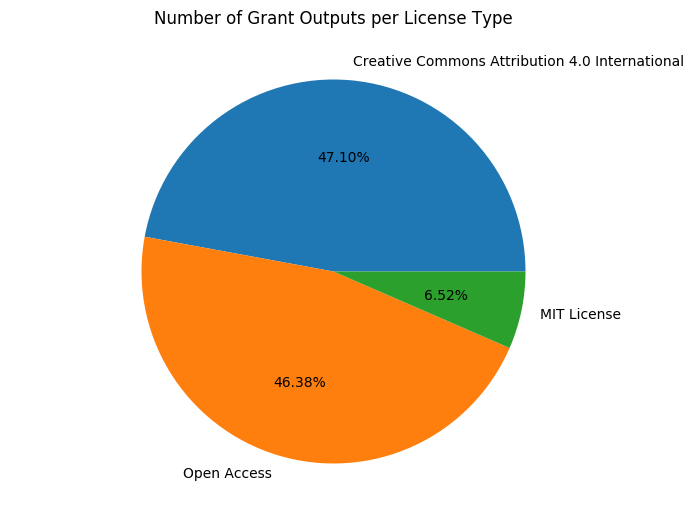

In [50]:
# Plot as a pie chart the number of outputs per license type
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import operator

xstr = lambda s: 'Not available' if s is None else str(s)

plt.rcdefaults()

# Retrieve works counts by resource type from nodes
funder = data['funder']
num_outputs_dict = {}
for r in funder['works']['nodes']:
    resourceType = xstr(r['types']['resourceType'])
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    for rights in r['rights']:
        right = xstr(rights['rights'])
        if right not in num_outputs_dict:
            num_outputs_dict[right] = 0
        num_outputs_dict[right] += 1;
    
# Sort resource types by count of work desc
sorted_num_outputs = sorted(num_outputs_dict.items(),key=operator.itemgetter(1),reverse=True)
# Populate lists needed for pie chart
resource_types = [s[0] for s in sorted_num_outputs] 
num_outputs = [s[1] for s in sorted_num_outputs] 

# Generate a pie chart of number of grant outputs by resource type
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of Grant Outputs per License Type')
ax.axis('equal')
ax.pie(num_outputs, labels = resource_types,autopct='%1.2f%%')
plt.show()

## Plot license type counts per resources type
Plot stacked bar plot showing how <ins>each type</ins> of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs contributes their license type counts to the corresponding aggregated total.


In [56]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd

xstr = lambda s: 'General' if s is None else str(s)
xstr1 = lambda s: 'Not available' if s is None else str(s)

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
def px_stacked_bar(df, color_name='License Type', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)
 
# Collect metric counts
funder = data['funder']
funderName = funder['name']
awardTitle = None

# Initialise dicts for the stacked bar plot
labels = {0: 'All Output Types'}

# Map each license type to a dict in turn mapping the position of the output's bar in plot 
# to the count of outputs corresponding to that license type
licenseType2Pos2Count = {}

# Collect output type labels and assign bar positions in plot
outputTypesSet = set([])
outputType2Pos = {}
for node in funder['works']['nodes']:
    if node['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue    
    resource_type = xstr(node['types']['resourceType'])
    outputTypesSet.add(resource_type)
    if not awardTitle:
        awardTitle = node['fundingReferences'][0]['awardTitle']
outputTypes = list(outputTypesSet);    
for pos, outputType in enumerate(outputTypes):
    labels[pos + 1] = outputType
    outputType2Pos[outputType] = pos + 1
    
# Populate license type counts per output type (key = i) and add them to the aggregated counts (key: 0)
for node in funder['works']['nodes']:
    if node['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue       
    resource_type = xstr(node['types']['resourceType'])
    pos = outputType2Pos[resource_type]
    for rights in node['rights']:
        right = xstr1(rights['rights'])
        if right not in licenseType2Pos2Count:
            licenseType2Pos2Count[right] = {}
            for pos1, _ in enumerate(labels):
                # Initialise right's counts for each output type
                licenseType2Pos2Count[right][pos1] = 0
        licenseType2Pos2Count[right][0] += 1 
        licenseType2Pos2Count[right][pos] += 1

# Create stacked bar plot
x_name = "Output Types"
dfDict = {x_name: labels}

for right in licenseType2Pos2Count:
    dfDict[right] = licenseType2Pos2Count[right]

df = pd.DataFrame(dfDict)
fig = px_stacked_bar(df.set_index(x_name), y_name = "Output Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='out.html')

# Display plot from the saved html file
# TODO: Change header below - incorporate awardTitle
display(Markdown("License Types of %s's [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs, shown per output type as a stacked bar plot:" % funderName))
IFrame(src="./out.html", width=500, height=500)

License Types of European Commission's [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs, shown per output type as a stacked bar plot: